In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rice_ml.unsupervised_learning import KMeans

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 5)

df = pd.read_csv("../data/lesions_processed.csv")
df.head()


,x_norm,y_norm,slice_norm,r_xy,quad_x,quad_y,experiment,tampered,type,uuid,slice,x,y
0,0.678571,0.945409,0.198413,499.489740,1,1,1,1,FB,1280,100,323,381
1,0.743697,0.714640,0.150794,456.355125,1,1,1,1,FB,1009,76,354,288
2,0.342437,0.473945,0.156746,251.097591,0,0,1,1,FB,7794,79,163,191
3,0.710084,0.602978,0.186508,416.284758,1,1,1,1,FB,7794,94,338,243
4,0.327731,0.334988,0.089286,206.303175,0,0,1,1,FB,2997,45,156,135


In [4]:
#feature to cluster
feature_cols = ["x_norm", "y_norm", "slice_norm", "r_xy"]
X = df[feature_cols].values

# true labels only for evaluation after clustering (NOT in training)
y_true = df["tampered"].values.astype(int)

X.shape, y_true.shape


((169, 4), (169,))

In [5]:
#standardize
mean_ = X.mean(axis=0)
std_ = X.std(axis=0)
std_[std_ == 0] = 1.0

X_scaled = (X - mean_) / std_


In [6]:
#fit with k=2
kmeans = KMeans(n_clusters=2, max_iter=300, tol=1e-4, random_state=42)
kmeans.fit(X_scaled)

cluster_labels = kmeans.predict(X_scaled)
np.unique(cluster_labels, return_counts=True)


(array([0, 1]), array([ 22, 147]))

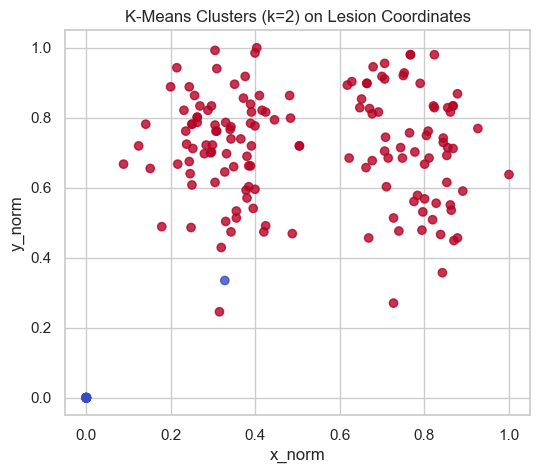

In [8]:
#visualize
plt.figure(figsize=(6,5))
plt.scatter(df["x_norm"], df["y_norm"], c=cluster_labels, cmap="coolwarm", alpha=0.8)
plt.xlabel("x_norm")
plt.ylabel("y_norm")
plt.title("K-Means Clusters (k=2) on Lesion Coordinates")
plt.show()


One cluster captures the vast majority of tampered points, while the other contains most real points. This suggests that tampered lesions occupy a distinct region of feature space, even without labels.

In [9]:
#compare to true labels
acc_same = np.mean(cluster_labels == y_true)
acc_flip = np.mean((1 - cluster_labels) == y_true)

cluster_accuracy = max(acc_same, acc_flip)
cluster_accuracy


np.float64(0.7869822485207101)

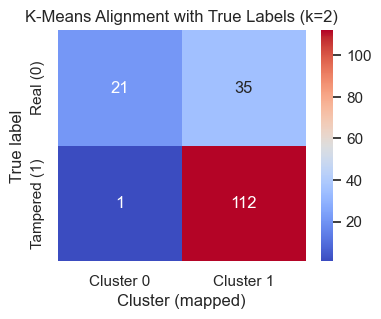

In [10]:
#confusion matrix
if acc_flip > acc_same:
    cluster_mapped = 1 - cluster_labels
else:
    cluster_mapped = cluster_labels

cm = np.zeros((2, 2), dtype=int)
for yt, yp in zip(y_true, cluster_mapped):
    cm[yt, yp] += 1

cm

import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="coolwarm",
    xticklabels=["Cluster 0", "Cluster 1"],
    yticklabels=["Real (0)", "Tampered (1)"]
)
plt.title("K-Means Alignment with True Labels (k=2)")
plt.ylabel("True label")
plt.xlabel("Cluster (mapped)")
plt.show()



I want to explore whether there is a bias between blind and open trials. Cluster distributions by experiment help check whether the data collection context changes the structure in feature space. Does simply knowing this is an experiemtn change results?

In [11]:
#knowledge bias
out = df.copy()
out["cluster"] = cluster_mapped

pd.crosstab(out["experiment"], out["cluster"], normalize="index")

#cluster vs true label
pd.crosstab(out["experiment"], out["tampered"], normalize="index")
pd.crosstab([out["experiment"], out["tampered"]], out["cluster"], normalize="index")



cluster                     0         1
experiment tampered                    
1          0         0.394737  0.605263
           1         0.010526  0.989474
2          0         0.333333  0.666667
           1         0.000000  1.000000

When stratifying by experiment, we can observe stronger clusters in Experiment 2 compared to Experiment 1. This suggests that knowledge bias may influence lesion placement or detection, making tampered regions more spatially consistent in the open trial.